#Setup & Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#Data import
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

!pip install yfinance --upgrade --no-cache-dir
yf.pdr_override()

#For mounting to drive
from google.colab import drive


#Modeling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

#Modeling Metrics
from sklearn import metrics


Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.45)


In [2]:

#Mount folder to save and retrieve outputs
drive.mount('/content/Drive3',force_remount=True)
%cd "/content/Drive3/My Drive/ML/StockModels/"

Mounted at /content/Drive3
/content/Drive3/My Drive/ML/StockModels


#Import Data and Discovery

In [3]:

df_full = pdr.get_data_yahoo("AAPL", start="2018-01-01").reset_index()

df_full.to_csv('output/AAPL.csv',index=False)


[*********************100%***********************]  1 of 1 downloaded


In [4]:
df_full.shape

(428, 7)

In [5]:
df_full.head()

Date        Open        High  ...       Close   Adj Close    Volume
0 2018-01-02  170.160004  172.300003  ...  172.259995  167.701889  25555900
1 2018-01-03  172.529999  174.550003  ...  172.229996  167.672668  29517900
2 2018-01-04  172.539993  173.470001  ...  173.029999  168.451508  22434600
3 2018-01-05  173.440002  175.369995  ...  175.000000  170.369385  23660000
4 2018-01-08  174.350006  175.610001  ...  174.350006  169.736588  20567800

[5 rows x 7 columns]

In [6]:
df_full.describe()

Open        High         Low       Close   Adj Close        Volume
count  428.000000  428.000000  428.000000  428.000000  428.000000  4.280000e+02
mean   189.269603  191.171963  187.492664  189.349767  186.869200  3.192506e+07
std     19.699378   19.786240   19.615980   19.701987   19.931548  1.362092e+07
min    143.979996  145.720001  142.000000  142.190002  140.505798  1.136200e+07
25%    174.087502  175.149994  172.712498  174.240005  171.164211  2.239458e+07
50%    188.365005  189.769997  186.779999  188.525002  185.567421  2.844490e+07
75%    204.292495  206.432495  202.992496  204.507500  203.391636  3.787712e+07
max    230.779999  233.470001  229.779999  232.070007  228.523819  9.624670e+07

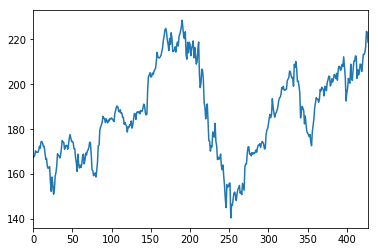

In [7]:

df_full["Adj Close"].plot()

# Data Preproccessing


In [0]:
df_full.set_index("Date", inplace=True)

In [0]:
window_size=32
num_samples=len(df_full)-window_size

# Get indices of access for the data
indices=np.arange(num_samples).astype(np.int)[:,None]+np.arange(window_size+1).astype(np.int)


data = df_full['Adj Close'].values[indices] # Create the 2D matrix of training samples
x = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day


In [0]:
split_fraction=0.8
ind_split=int(split_fraction*num_samples)

In [0]:
x_train = x[:ind_split]
y_train = y[:ind_split]
x_test = x[ind_split:]
y_test = y[ind_split:]

In [12]:
y_test.shape

(80,)

#Modeling and Adding perfomance check for all Models

In [0]:
#Help Functions
def get_performance (model_pred):
  #Function returns standard performance metrics
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, model_pred).round(4))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, model_pred).round(4))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, model_pred)).round(4))
  
  
  
def get_plot (model_pred):
  plt.scatter(model_pred, y_test, color="gray")
  plt.plot(y_test, y_test, color='red', linewidth=2)

## Baseline

In [0]:
y_pred_lag=np.roll(y_test,1)

In [19]:
get_performance(y_pred_lag)

Mean Absolute Error: 2.9604
Mean Squared Error: 27.7842
Root Mean Squared Error: 5.2711


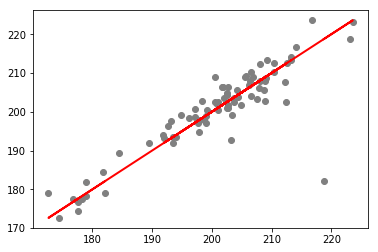

In [17]:
get_plot(y_pred_lag)

## Linear Regression

In [20]:
model_lr=LinearRegression()
model_lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred_lr=model_lr.predict(x_test)

In [22]:
get_performance(y_pred_lr)

Mean Absolute Error: 2.9299
Mean Squared Error: 13.7611
Root Mean Squared Error: 3.7096


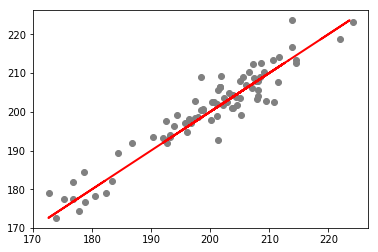

In [23]:
get_plot(y_pred_lr)

In [24]:
get_performance(y_pred_lr)

Mean Absolute Error: 2.9299
Mean Squared Error: 13.7611
Root Mean Squared Error: 3.7096


## Method #1- Ridge Regression

In [0]:
model_ridge = Ridge()
model_ridge.fit(x_train, y_train)

#generate predictions
y_pred_ridge=model_ridge.predict(x_test)

In [26]:
get_performance(y_pred_ridge)

Mean Absolute Error: 2.9297
Mean Squared Error: 13.7587
Root Mean Squared Error: 3.7093


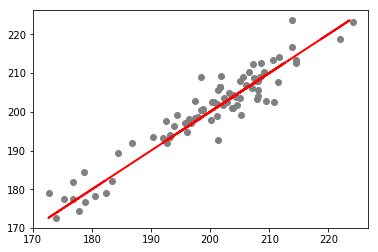

In [27]:
get_plot(y_pred_ridge)

## Gradient Boosting Trees

In [0]:
# Model #2 - Gradient Boosting Trees
model_gb = GradientBoostingRegressor()
model_gb.fit(x_train, y_train)

# Infer
y_pred_gb = model_gb.predict(x_test)

In [29]:
get_performance(y_pred_gb)

Mean Absolute Error: 3.5132
Mean Squared Error: 17.8919
Root Mean Squared Error: 4.2299


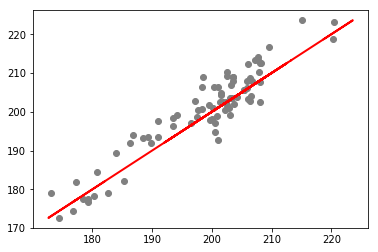

In [30]:
get_plot(y_pred_gb)

# Comparison

In [0]:
df_comp=pd.DataFrame({"lag":np.absolute(y_test-y_pred_lag), 
              "lr":np.absolute(y_test-y_pred_lr), 
              "ridge":np.absolute(y_test-y_pred_ridge),
              "gb":np.absolute(y_test-y_pred_gb)})

In [32]:
df_comp.plot.bar(figsize=(16, 6))
plt.ylim(0,10)
plt.xlim(9,20)

(9, 20)

# Conclusion and Next Steps

We cycled through 4 different algorithms, ranging from simple to complex:

*   lag (previous day's price)
*   linear regression
*   ridge regresssion
*   gradient boosting trees

We concluded that linear regression give us the best performance with the least complexity.

Next steps might include adding additional features such as trend and recent volatility.



# Resources



*   [An Introduction to Statistical Learning](https://www.amazon.com/Introduction-Statistical-Learning-Applications-Statistics/dp/1461471370)
*   [Colab: Agent Trading](https://colab.research.google.com/drive/1FzLCI0AO3c7A4bp9Fi01UwXeoc7BN8sW#scrollTo=Lo2Pg-dcY5_U)
*   [In 12 minutes: Stocks Analysis with Pandas and Scikit-Learn](https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7)
*   [A beginnerâ€™s guide to Linear Regression in Python with Scikit-Learn](https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f)






